# Importing Python modules

In [326]:
import numpy as np
import pywt
from scipy import signal
from biosppy.signals import ecg

%matplotlib inline
import matplotlib.pyplot as plt

 # ECG Signal

In [305]:
ch = 1

In [306]:

dispTime = 5
fs = 360

In [307]:
data = np.loadtxt('mit_arrythmia/100.txt',dtype = int)[:,ch]
print "Loaded ECG Signal CH #",ch
print "Samples Count : ", data.shape[0]
print "File Loaded"

Loaded ECG Signal CH # 1
Samples Count :  650000
File Loaded


In [308]:
def printSecSamples(data,start,end,t):
    print "Sample Count in the first " + str(end - start ) + " second(s) ", data[(t >= start ) & (t <= end)].shape[0] 

In [309]:
t1 = np.linspace(0,1.* data.shape[0] / fs, data.shape[0])
printSecSamples(data,0,5,t1);


Sample Count in the first 5 second(s)  1800


# Doing Wavelet Transform on ECG Signal for Compression

In [310]:
def applyWaveletTransform(data,wavelet,cascadeFactor):
    cA = data
    for i in range(cascadeFactor):
        cA,cD = pywt.dwt(cA,wavelet)
    return cA

In [311]:
def compressEcgSignal(sig,t,cascadeFactor):
    
    print "ECG Signal # of Samples: ", sig.shape[0]
    
    compressedSignal = applyWaveletTransform(sig,'db1',cascadeFactor)
    tNew = np.linspace(0, t[-1] , compressedSignal.shape[0])
    
    print "Compressed ECG Signal # of Samples (Cascading Factor : " + str(cascadeFactor) + ")", compressedSignal.shape[0]
   
    printSecSamples(compressedSignal,0,5,tNew)
    
    return compressedSignal, tNew



In [312]:
cascade = 1
ecgSignalC1, t2 = compressEcgSignal(x,t1,cascade)

print "------------------------------"

cascade += 1
ecgSignalC2, t3 =compressEcgSignal(x,t1,cascade)



ECG Signal # of Samples:  3
Compressed ECG Signal # of Samples (Cascading Factor : 1) 2
Sample Count in the first 5 second(s)  1
------------------------------
ECG Signal # of Samples:  3
Compressed ECG Signal # of Samples (Cascading Factor : 2) 1
Sample Count in the first 5 second(s)  1


In [313]:
def displayEcgSignal(t,sig,xMin,xMax,title):
    plt.figure( figsize = (16,3))
    plt.plot(t,sig)
    plt.xlim(xMin,xMax)
    
    ymin = np.amin(sig[(t >= xMin) & (t <= xMax)], axis = 0)
    ymax = np.amax(sig[(t >= xMin) & (t <= xMax)], axis = 0)
    
    plt.ylim(ymin - 50 ,ymax + 50)
    plt.grid()
    plt.title(title)
    plt.show()

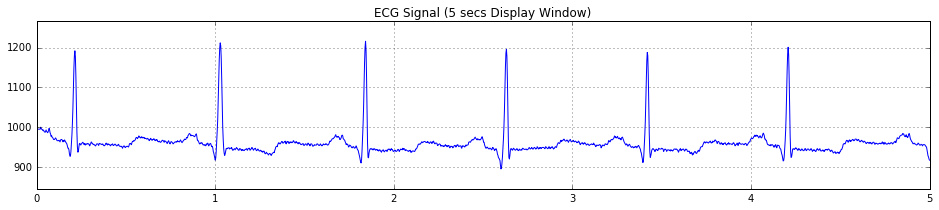

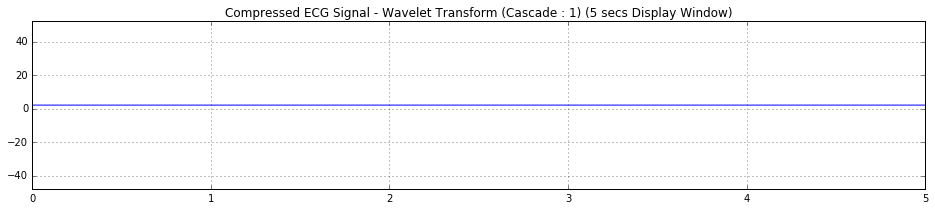

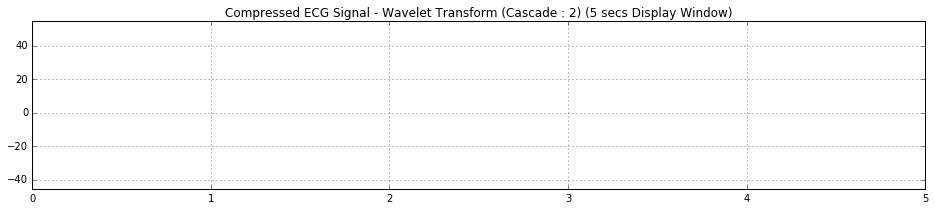

In [314]:

# Display Original ECG Signal
title1 = "ECG Signal (" + str(dispTime) + " secs Display Window)"
displayEcgSignal(t1,data,0,dispTime,title1)

# Display Compressed ECG Signal (C1)
title2 = "Compressed ECG Signal - Wavelet Transform (Cascade : 1) (" + str(dispTime) + " secs Display Window)"
displayEcgSignal(t2,ecgSignalC1,0,dispTime,title2)

# Display Compressed ECG Signal (C2)
title3 = "Compressed ECG Signal - Wavelet Transform (Cascade : 2) (" + str(dispTime) + " secs Display Window)"
displayEcgSignal(t3,ecgSignalC2,0,dispTime,title3)


In [315]:
def sGolayFilter(sig):
    k = 3
    f = 1201
    trend = signal.savgol_filter(sig,f,k)
    fSig = sig - trend
    return fSig

In [316]:
def pipelineFilter(sig):
    
        # Moving Average Filter Coefficients
    a1 = np.array([1])
    b1 = np.ones(10) * ( 1. * 1/10)

    # First Derivative Based Filter Coefficients
    b2 = np.array([1,-1])
    a2 = np.array([1,-0.995])
    h, w = signal.freqz(b2,a2)
    scale = 1. * (1/max(h.real))
    b2 =  b2 * scale;

    # Comb / Notch Filter Coefficients
    b3 = np.array([0.6310,-0.2149,0.1512,-0.1288,0.1227,-0.1288,0.1512,-0.2149,0.6310]);
    a3 = np.array([1])

    aPipe = signal.fftconvolve(a1,a2, mode = 'same')
    aPipe = signal.fftconvolve(aPipe,a3 , mode = 'same')

    bPipe = signal.fftconvolve(b1,b2, mode = 'same')
    bPipe = signal.fftconvolve(bPipe,b3, mode = 'same')

    fSig = signal.lfilter(bPipe,aPipe,ecgSignal)

    plt.figure( figsize = (16,3))
    plt.plot(t,fSig)
    plt.ylim(15,22)
    plt.grid()
    plt.title("Pipeline Filter (MA, Derivative, Comb/Notch) - ECG Signal")

    #line = np.zeros(int(t.shape[0]))
    #plt.plot(t,line,'r')
    plt.show()


In [317]:
def movingAverageFilter(sig, length):
    b = np.ones(length) * ( 1. * 1/length)
    a = 1
    fSig = signal.lfilter(b, a, sig)
    return fSig

In [318]:
def derivativeBasedFilter(sig):
    b = np.array([1,-1])
    a = np.array([1,-0.995])
    h, w = signal.freqz(b,a)
    scale = 1. * (1/max(h.real))
    b =  b * scale;
    fSig = signal.lfilter(b,a,ecgSignal)
    return fSig

In [319]:
def combNotchFilter(sig):
    b = np.array([0.6310,-0.2149,0.1512,-0.1288,0.1227,-0.1288,0.1512,-0.2149,0.6310]);
    a = 1
    fSig = signal.lfilter(b, a, sig)
    return fSig

In [320]:
def displayEcgSignal2(t,sig,title):
    
    plt.figure( figsize = (16,3))
    plt.plot(t,sig)
    
    ymin = np.amin(sig, axis = 0)
    ymax = np.amax(sig, axis = 0)
    
    plt.ylim(ymin - 20 ,ymax + 20)
    plt.grid()
    plt.title(title)
   
    line = np.zeros(int(t.shape[0]))
    plt.plot(t,line,'r')
    plt.show()
    
    

In [333]:
winSec = 5;
ecgSignal = data[(t1 >=0) & (t1<= winSec)]
t = t1[0:ecgSignal.shape[0]:1]
print "ECG Signal Subset done"

ECG Signal Subset done


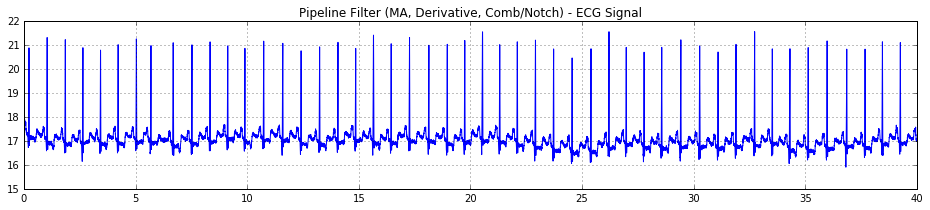

In [322]:
pipelineFilter(ecgSignal)

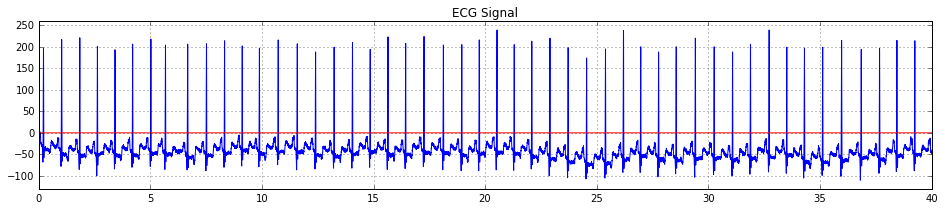

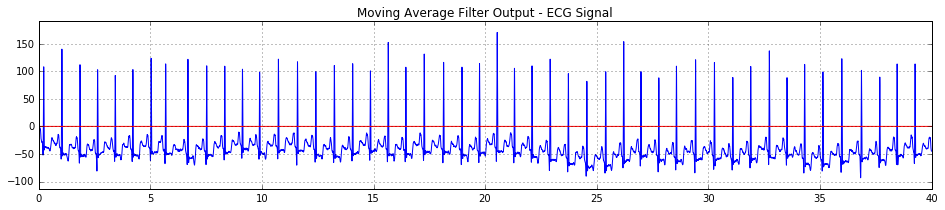

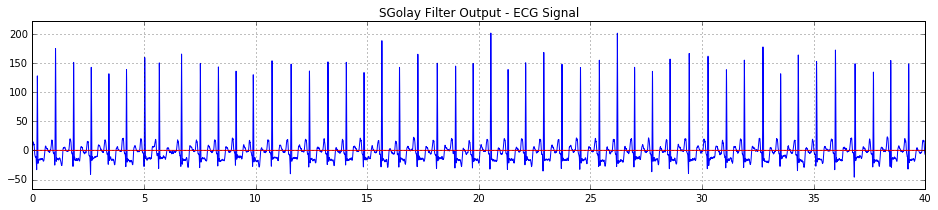

In [323]:
ecgSignal = ecgSignal - ecgSignal[0]
displayEcgSignal2(t,ecgSignal,"ECG Signal")

fEcgSignal = movingAverageFilter(ecgSignal, 10)
displayEcgSignal2(t,fEcgSignal,"Moving Average Filter Output - ECG Signal")

#fEcgSignal = combNotchFilter(fEcgSignal)
#displayEcgSignal2(t,fEcgSignal,"Comb Notch Filter Output - ECG Signal")


#fEcgSignal = derivativeBasedFilter(fEcgSignal)
#displayEcgSignal2(t,fEcgSignal,"First Derivative Based Filter Output - ECG Signal")

fEcgSignal = sGolayFilter(fEcgSignal)
displayEcgSignal2(t,fEcgSignal,"SGolay Filter Output - ECG Signal")

ecgSignalInt = fEcgSignal


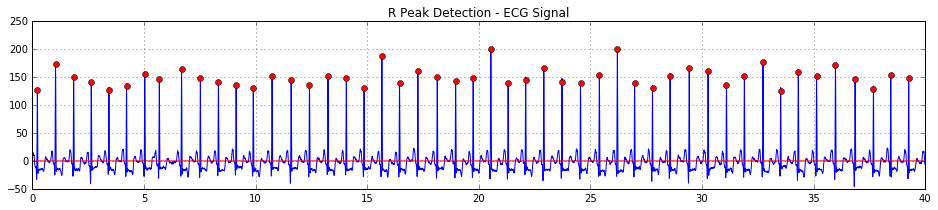

In [324]:
peaksIndices = signal.find_peaks_cwt(ecgSignalInt,np.arange(1,230))
peaksCount = peaksIndices.__len__()
peaks = []
for value in peaksIndices:
    if ecgSignalInt[value] > 50:
        peaks.append(value)
        
plt.figure(figsize = (16,3))
plt.plot(t,ecgSignalInt)
line = np.zeros(int(t.shape[0]))
plt.plot(t,line,'r')
plt.grid()
plt.title("R Peak Detection - ECG Signal")
plt.plot(t[peaks], ecgSignalInt[peaks], "ro")
plt.show()


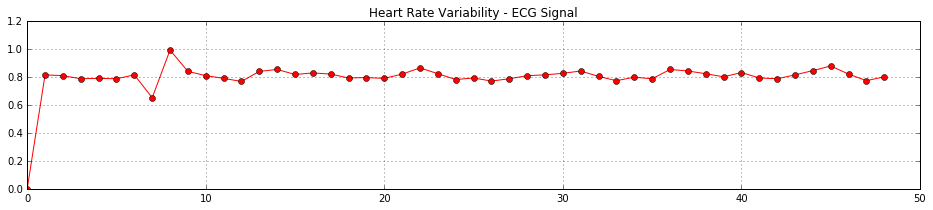

In [325]:
peaksList = np.array(peaks)
plt.figure(figsize = (16,3))
xPoints = np.arange(0,peaksList.shape[0])
hrv = np.insert(np.diff(t[peaksList]),0,0);

plt.title("Heart Rate Variability - ECG Signal")
plt.plot(xPoints,hrv,'ro-')
plt.ylim(0,1.2)
plt.grid()
plt.show()


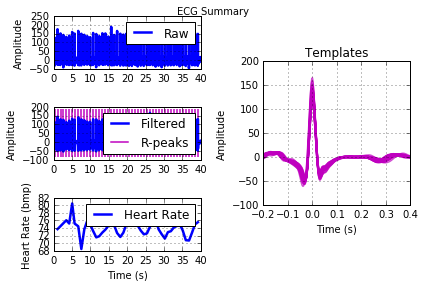

ReturnTuple(ts=array([  0.00000000e+00,   2.77758488e-03,   5.55516975e-03, ...,
         3.99888895e+01,   3.99916671e+01,   3.99944446e+01]), filtered=array([ 0.56323572,  0.79266001,  1.02800331, ..., -1.05541889,
       -0.64461406, -0.2862238 ]), rpeaks=array([   81,   374,   667,   951,  1235,  1519,  1813,  2048,  2407,
        2710,  3002,  3287,  3564,  3867,  4174,  4470,  4769,  5064,
        5351,  5638,  5923,  6218,  6531,  6828,  7110,  7396,  7674,
        7957,  8250,  8543,  8841,  9146,  9436,  9714, 10002, 10286,
       10595, 10899, 11196, 11484, 11785, 12070, 12354, 12649, 12954,
       13270, 13566, 13846, 14135]), templates_ts=array([ -2.00000000e-01,  -1.97222222e-01,  -1.94444444e-01,
        -1.91666667e-01,  -1.88888889e-01,  -1.86111111e-01,
        -1.83333333e-01,  -1.80555556e-01,  -1.77777778e-01,
        -1.75000000e-01,  -1.72222222e-01,  -1.69444444e-01,
        -1.66666667e-01,  -1.63888889e-01,  -1.61111111e-01,
        -1.58333333e-01,  -1.5555555